In [6]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
fires = pd.read_csv('fires.csv')

In [3]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [5]:
fires.shape

(517, 14)

# Exploratory data analysis
The dataset, is about meterological observations and forest fires in Portugal.
It is available [Here](https://archive.ics.uci.edu/dataset/162/forest+fires)


## Data structure

| Variable Name | Role     | Type        | Description                                                                                             | Units         | Missing Values |
|---------------|----------|-------------|---------------------------------------------------------------------------------------------------------|---------------|----------------|
| `X`           | Feature  | Integer     | x-axis spatial coordinate within the Montesinho park map: 1 to 9                                        |               | no             |
| `Y`           | Feature  | Integer     | y-axis spatial coordinate within the Montesinho park map: 2 to 9                                        |               | no             |
| `month`       | Feature  | Categorical | month of the year: 'jan' to 'dec'                                                                       |               | no             |
| `day`         | Feature  | Categorical | day of the week: 'mon' to 'sun'                                                                         |               | no             |
| `FFMC`        | Feature  | Continuous  | FFMC index from the FWI system: 18.7 to 96.20                                                           |               | no             |
| `DMC`         | Feature  | Integer     | DMC index from the FWI system: 1.1 to 291.3                                                             |               | no             |
| `DC`          | Feature  | Continuous  | DC index from the FWI system: 7.9 to 860.6                                                              |               | no             |
| `ISI`         | Feature  | Continuous  | ISI index from the FWI system: 0.0 to 56.10                                                             |               | no             |
| `temp`        | Feature  | Continuous  | temperature: 2.2 to 33.30                                                                               | Celsius       | no             |
| `RH`          | Feature  | Integer     | relative humidity: 15.0 to 100                                                                          | %             | no             |
| `wind`        | Feature  | Continuous  | wind speed: 0.40 to 9.40                                                                                | km/h          | no             |
| `rain`        | Feature  | Integer     | outside rain: 0.0 to 6.4                                                                                | mm/m²         | no             |
| `area`        | Target   | Integer     | the burned area of the forest: 0.00 to 1090.84  | ha            | no             |

The [Fire Weather Index (FWI)](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi) is a system to assign a
numerical value to risk of forest fires. The hierarchy of how these observations are tied together is shown in this
image

![FWI System](FWI.png)


The 4 values in this data set from it are
- `FFMC` : Fine Fuel Moisture Code (dry grass and small twigs)
- `DMC` : Duff Moisture Code (moisture content of medium -ized organic material, it is sensitive to rainfall and
temperature)
- `DC`: Drought Code
- `ISI`: Initial Spread Index

C:\Users\User\Dataquest.IO\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\User\Dataquest.IO\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


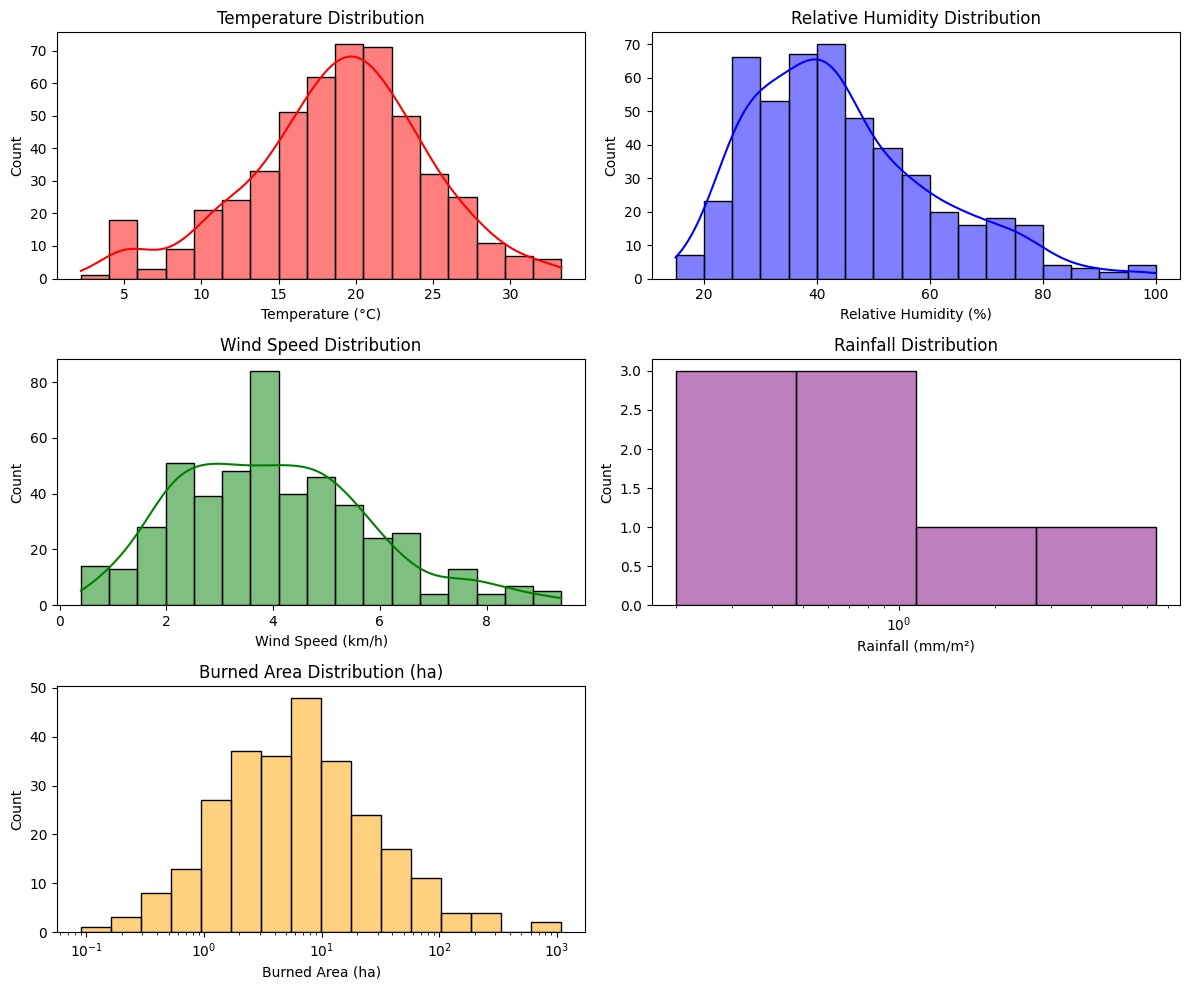

In [17]:
# Arrange distributions in a grid using seaborn and matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

sns.histplot(fires['temp'], kde=True, ax=axes[0], color='red')
axes[0].set_title('Temperature Distribution')
axes[0].set_xlabel('Temperature (°C)')

sns.histplot(fires['RH'], kde=True, ax=axes[1], color='blue')
axes[1].set_title('Relative Humidity Distribution')
axes[1].set_xlabel('Relative Humidity (%)')

sns.histplot(fires['wind'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Wind Speed Distribution')
axes[2].set_xlabel('Wind Speed (km/h)')

sns.histplot(fires['rain'], kde=True, ax=axes[3], log_scale=(True, False), bins='auto', color='purple')
axes[3].set_title('Rainfall Distribution')
axes[3].set_xlabel('Rainfall (mm/m²)')

sns.histplot(fires['area'], kde=True, ax=axes[4], log_scale=(True, False), color='orange')
axes[4].set_title('Burned Area Distribution (ha)')
axes[4].set_xlabel('Burned Area (ha)')

# Remove the empty plot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()